In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import os

from sklearn.preprocessing import LabelEncoder
from functions import equal, find_nearest, impute_immediate_mean, impute_mean_day, daylight_savings_shift, clean_weather

## Weather Data

In [2]:
cities = ['madrid', 'seville', 'barcelona', 'bilbao', 'valencia']
dfs = []
for city in cities:
    
    # Read in city dataframe
    city_df = pd.read_csv(f'../data/weather/{city}.csv', index_col=0)

    # Clean the madrid data
    city_df = clean_weather(city_df)

    # Rename columns
    city_df.columns = city_df.columns + f'_{city}'
    
    dfs.append(city_df)
    
# Create daterange
index = pd.date_range(start=dt.datetime(2015,1,1),
                      end = dt.datetime(2021,12,31, 23),
                      freq='H')
range_ = pd.DataFrame(index=index)

# Join to date range in weather data
weather = range_.join([dfs[0], dfs[1], dfs[2], dfs[3], dfs[4]])

# Drop unnecessary columns
weather.drop(columns=['index_madrid', 'index_seville', 'index_barcelona',
                      'index_bilbao', 'index_valencia'],
             inplace=True)

# Get list of categoricals and continuous variables
categorical = weather.select_dtypes(include='object').columns
continuous = weather.select_dtypes(exclude='object').columns

# Impute the mean day for continuous variables with 12 or more missing
for col in continuous:
    impute_mean_day(weather, col, 12)

# Interpolate remaining continuous Nans
weather.loc[:, continuous] = weather.loc[:, continuous].interpolate(limit=12)

# Back fill categorical nans
weather.loc[:,categorical] = weather[categorical].fillna(value='unknown')

# Back fill remaining nans (first five rows of dataset)
weather = weather.fillna(method='bfill')

# Drop duplicates in the index
weather.reset_index(inplace=True)
weather.drop_duplicates(subset='index', inplace=True)
weather.set_index('index', inplace=True)

# Drop precips cols
weather.drop(columns = weather.filter(regex='precips').columns, inplace=True)

# Lag the columns one day
weather_lag = weather.shift(1, freq='D')

# Rename weather_lag columns
lag_names = [col+'_lag' for col in weather_lag.columns]
lag_dict = dict(zip(weather_lag.columns, lag_names))
weather_lag.rename(columns=lag_dict, inplace=True)

# Export to clean folder
weather.to_csv('../data/clean/weather_clean.csv')
weather_lag.to_csv('../data/clean/weather_lag_clean.csv')

## Cross Border Transmission Data

In [3]:
# Read in France Border Data
france = pd.DataFrame()
portugal = pd.DataFrame()

for file in os.listdir('../data/cross_border/france'):
    data = pd.read_csv(f'../data/cross_border/france/{file}')
    data.drop_duplicates(subset='Time (CET)', inplace=True)
    france = pd.concat([france, data],axis=0)

# Convert Time to datetime
france['time'] = france['Time (CET)'].apply(lambda x: x[:13])
france['time'] = pd.to_datetime(france['time'], format="%d.%m.%Y %H")
france = france.set_index('time').drop(columns='Time (CET)')

# Read in Portugal Border Data
for file in os.listdir('../data/cross_border/portugal'):
    data = pd.read_csv(f'../data/cross_border/portugal/{file}')
    data.drop_duplicates(subset='Time (CET)', inplace=True)
    portugal = pd.concat([portugal, data],axis=0)
portugal['time'] = portugal['Time (CET)'].apply(lambda x: x[:13])
portugal['time'] = pd.to_datetime(portugal['time'], format="%d.%m.%Y %H")
portugal = portugal.set_index('time').drop(columns='Time (CET)')

# Join France and Portugal Data
border = portugal.join(france)
border.fillna(method='ffill', inplace=True)
cols = dict(zip(border.columns,['transmission_ps', 
                                'transmission_sp', 
                                'transmission_fs',
                                'transmission_sf']))

border.rename(columns=cols, inplace=True)

# lag border data and rename cols
border_lag = border.shift(1, freq='D')
lag_names = [col+'_lag' for col in border_lag.columns]
lag_dict = dict(zip(border_lag.columns, lag_names))
border_lag.rename(columns=lag_dict, inplace=True)

# Export to clean folder
border.to_csv('../data/clean/border_clean.csv')
border_lag.to_csv('../data/clean/border_lag_clean.csv')

## Generation

In [4]:
gen = pd.DataFrame()
for file in os.listdir('../data/generation'):
    load = pd.read_csv(f'../data/generation/{file}')
    load.drop_duplicates(subset='MTU', inplace=True)
    gen = pd.concat([gen, load], axis=0)
    
# Get rid of columns that do not contain any information
gen = gen.drop(columns = gen.loc[:,gen.nunique()<=1].columns)

# Convert Time to datetime
gen['time'] = pd.to_datetime(gen[gen.columns[0]].apply(lambda x: x[:13]),
                             format="%d.%m.%Y %H")

# Set index to the time col
gen.set_index('time', inplace=True)

# Drop MTU col
gen.drop(columns='MTU', inplace=True)

# Rename cols
gen.columns = gen.columns.map(lambda x: ('generation '+ x[:-26]).lower())
gen.rename(columns={'generation hydro pumped storage ': 'generation hydro pumped storage consumption'},
           inplace=True)

# Impute Immediate Mean for NaNs
for col in gen.columns:
    indices = gen.loc[gen[col].isna()].index
    for i in indices:
        gen.loc[i,col] = impute_immediate_mean(gen[col], i)

# Rename cols
col_map = dict(zip(gen.columns, [col.split(' ')[-1] for col in gen.columns]))
gen.rename(columns=col_map, inplace=True)

# Shift columns
gen_lag = gen.shift(1, freq='D')

# Rename Lag Columns
col_map = dict(zip(gen.columns, [col + '_lag' for col in gen.columns]))
gen_lag.rename(columns=col_map, inplace=True)

# Export to clean folder
gen.to_csv('../data/clean/generation_clean.csv')
gen_lag.to_csv('../data/clean/generation_lag_clean.csv')

## Load Forecast and Actual

In [5]:
load_forecast = pd.DataFrame()
for file in os.listdir('../data/load'):
    load = pd.read_csv(f'../data/load/{file}')
    if load.columns[0] == 'Time (CET/CEST)':
        load.rename(columns={'Time (CET/CEST)':'Time (CET)'}, inplace=True)
    load.drop_duplicates(subset=load.columns[0], inplace=True)
    load_forecast = pd.concat([load_forecast, load], axis=0)

# Convert Time to datetime
load_forecast['time'] = pd.to_datetime(load_forecast['Time (CET)'].apply(lambda x: x[:13]),
                                       format="%d.%m.%Y %H")

# Set index to the time col
load_forecast.set_index('time', inplace=True)

# Drop 'Time (CET)' col
load_forecast.drop(columns='Time (CET)', inplace=True)

# Rename cols
load_forecast.rename(columns = {'Day-ahead Total Load Forecast [MW] - BZN|ES':'load_forecast',
                                'Actual Total Load [MW] - BZN|ES':'load_actual'}, 
                     inplace=True)

# Impute Immediate Mean for NaNs
for col in load_forecast.columns:
    indices = load_forecast.loc[load_forecast[col].isna()].index
    for i in indices:
        load_forecast.loc[i,col] = impute_immediate_mean(load_forecast[col], i)
        
# Shift load_actual
load_forecast_lag = load_forecast.join(load_forecast.load_actual.shift(1, 'D'), how='outer', lsuffix='_drop')
load_forecast_lag.drop(columns='load_actual_drop', inplace=True)

# Rename Lagged cols
load_forecast_lag.rename(columns={'load_actual':'load_actual_lag'}, inplace=True)

# Export to clean folder
load_forecast.to_csv('../data/clean/load_forecast_clean.csv')
load_forecast_lag.to_csv('../data/clean/load_forecast_lag.csv')

## Wind and Solar Forecast

In [7]:
ws = pd.DataFrame()
for file in os.listdir('../data/wind_solar_day_ahead'):
    load = pd.read_csv(f'../data/wind_solar_day_ahead/{file}')
    if load.columns[0] != 'Time (CET)':
        load.rename(columns={load.columns[0]:'Time (CET)'}, inplace=True)
    load.drop_duplicates(subset=['Time (CET)'], inplace=True)
    ws = pd.concat([ws, load], axis=0)

# Convert Time to datetime
ws['time'] = pd.to_datetime(ws[ws.columns[0]].apply(lambda x: x[:13]),
                                       format="%d.%m.%Y %H")

# Set index to the time col
ws.set_index('time', inplace=True)

# Drop 'Time (CET)' col
ws = ws[['Generation - Solar  [MW] Day Ahead/ BZN|ES',
         'Generation - Wind Onshore  [MW] Day Ahead/ BZN|ES']].copy()

# Rename cols
ws.rename(columns = {'Generation - Solar  [MW] Day Ahead/ BZN|ES':'solar_forecast',
                     'Generation - Wind Onshore  [MW] Day Ahead/ BZN|ES':'wind_forecast'}, 
                     inplace=True)

# 2020-05-01 wind forecast is missing, impute average for that day in may
avg_w = ws['wind_forecast'].groupby(by=[ws.index.month, 
                                        ws.index.day,
                                        ws.index.hour]).mean().loc[(5,1)]
for i, time in enumerate(ws.loc['2020-05-01'].index):
    ws.loc[time, 'wind_forecast'] = avg_w[i]
    
# Impute the immediate mean for remaining NaNs
for col in ws.columns:
    indices = ws.loc[ws[col].isna()].index
    for i in indices:
        ws.loc[i,col] = impute_immediate_mean(ws[col], i)
        
# Shift columns
ws_lag = ws.shift(1, freq='D')

# Rename Lag Columns
col_map = dict(zip(ws_lag.columns, [col + '_lag' for col in ws_lag.columns]))
ws_lag.rename(columns=col_map, inplace=True)

# Export to clean folder
ws.to_csv('../data/clean/wind_solar_clean.csv')
ws_lag.to_csv('../data/clean/wind_solar_clean_lag.csv')

## Generation Forecast Day ahead

In [10]:
# Load and combine all day ahead price data into single dataframe
gen_forecast = pd.DataFrame()
for file in os.listdir('../data/gen_forecast'):
    load = pd.read_csv(f'../data/gen_forecast/{file}')
    load.drop_duplicates(subset='MTU', inplace=True)
    gen_forecast = pd.concat([gen_forecast, load], axis=0)
    
# Convert Time to datetime
gen_forecast['time'] = gen_forecast['MTU'].apply(lambda x: x[:16])
gen_forecast['time'] = pd.to_datetime(gen_forecast['time'])

# Convert Time to datetime
gen_forecast['time'] = pd.to_datetime(gen_forecast[gen_forecast.columns[0]].apply(lambda x: x[:13]),
                                      format="%d.%m.%Y %H")

# Drop unused columns and rows
gen_forecast.drop(columns='MTU', inplace=True)

# Set index to the time col
gen_forecast.set_index('time', inplace=True)


# Rename cols
gen_forecast.rename(columns={'Scheduled Generation [MW] (D) - BZN|ES':'generation_forecast',
                             'Scheduled Consumption [MW] (D) - BZN|ES':'consumption_forecast'},
                    inplace=True)

for col in gen_forecast.columns:
    
    # Impute the mean of the nearest known date by hour
    impute_mean_day(gen_forecast, col, 24)
    
    # Fill remaining Nans
    gen_forecast[col].fillna(method='bfill', inplace=True)

# Export to clean folder
gen_forecast.to_csv('../data/clean/gen_forecast_clean.csv')

## Prices and Day Ahead Prices

In [11]:
# Change directory and get all files in data/price directory
os.chdir('../data/price')
files = os.listdir()

# Read all files in directory
prices = pd.DataFrame()
for file in files:
    prices =pd.concat([prices, pd.read_csv(file, delimiter=';', index_col=5, parse_dates=True)])

# Join on date_range to make sure we aren't missing any rows
price_df = pd.DataFrame(
    index=pd.date_range(start=dt.datetime(2015,1,1),
                        end=dt.datetime(2021,12,31,23),
                        freq='H',
                        tz='CET')
)

# Create cols dictionary to rename cols
cols = {'Hourly average price final sum of components':'price_actual',
        'Hourly average price Day Ahead market component':'price_day_ahead'}

cols = {'Hourly average price final sum of components':'price_actual',
       'Hourly average price intraday market tech. constraints component':'price_intraday_tech',
       'Hourly average price PBF technical constraints component':'price_PBF_tech',
       'Hourly average price real time technical constraints component':'price_rt_tech',
       'Hourly average price intraday market component':'price_intraday_market',
       'Hourly average price Day Ahead market component':'price_day_ahead',
       'Hourly average price Upward reserve power component':'price_upward_reserve',
       'Hourly average price secondary reserve component':'price_sec_reserve',
       'Hourly average price measured imbalances component': 'price_measured_imbalances',
       'Hourly average price imbalances net value component':'price_imbalances_net',
       'Hourly average price capacity payment component':'price_capacity_payment',
       'Hourly average price P.O.14.6 balance component':'price_P0146_balance',
       'Hourly average price Generic Units Nom. Failure component':'price_generic_failure',
       'Hourly average price interruptibility service component':'price_interupt_service',
       'Hourly average price power factor control component':'price_power_factor',
       'Hourly average price balance energy failure component':'price_balance_failure'}

# Create price dictionary to hold column data
price_dict = {cols[col]:prices.loc[prices.name==col, 'value'] for col in cols.keys()}

# For each column, add to price_df
for key in price_dict.keys():
    price_dict[key] = price_dict[key].rename(key)
    price_df = price_df.join(price_dict[key].groupby(by=price_dict[key].index).mean())

# Drop all the duplicates
price_df = price_df.groupby(by=price_df.index).mean().copy()

# Make timezone unaware, shift by an hour to offset the unaware tz
price_df.index = price_df.index.tz_convert(None)
price_df = price_df.shift(1, freq='H')

# Change directory back to ../script
os.chdir('../../scripts')

# Export to clean folder
price_df.to_csv('../data/clean/price_df_clean.csv')

In [77]:
# Change directory and get all files in data/price directory
os.chdir('../data/price/other')
files = os.listdir()

# Read all files in directory
prices = pd.DataFrame()
for file in files:
    prices =pd.concat([prices, pd.read_csv(file, delimiter=';', index_col=5, parse_dates=True)])

# Join on date_range to make sure we aren't missing any rows
price_df = pd.DataFrame(
    index=pd.date_range(start=dt.datetime(2015,1,1),
                        end=dt.datetime(2021,12,31,23),
                        freq='H',
                        tz='CET')
)

cols = {'Hourly average price final sum of components':'price_actual',
       'Hourly average price intraday market tech. constraints component':'price_intraday_tech',
       'Hourly average price PBF technical constraints component':'price_PBF_tech',
       'Hourly average price real time technical constraints component':'price_rt_tech',
       'Hourly average price intraday market component':'price_intraday_market',
       'Hourly average price Day Ahead market component':'price_day_ahead',
       'Hourly average price Upward reserve power component':'price_upward_reserve',
       'Hourly average price secondary reserve component':'price_sec_reserve',
       'Hourly average price measured imbalances component': 'price_measured_imbalances',
       'Hourly average price imbalances net value component':'price_imbalances_net',
       'Hourly average price capacity payment component':'price_capacity_payment',
       'Hourly average price P.O.14.6 balance component':'price_P0146_balance',
       'Hourly average price Generic Units Nom. Failure component':'price_generic_failure',
       'Hourly average price interruptibility service component':'price_interupt_service',
       'Hourly average price power factor control component':'price_power_factor',
       'Hourly average price balance energy failure component':'price_balance_failure'}

# Create price dictionary to hold column data
price_dict = {cols[col]:prices.loc[prices.name==col, 'value'] for col in cols.keys()}

# For each column, add to price_df
for key in price_dict.keys():
    price_dict[key] = price_dict[key].rename(key)
    price_df = price_df.join(price_dict[key].groupby(by=price_dict[key].index).mean())

# Drop all the duplicates
price_df = price_df.groupby(by=price_df.index).mean().copy()

# Make timezone unaware, shift by an hour to offset the unaware tz
price_df.index = price_df.index.tz_convert(None)
price_df = price_df.shift(1, freq='H')

#price_df.fillna(value=0, inplace=True)
# Change directory back to ../script
os.chdir('../../../scripts')

# Export to clean folder
#price_df.to_csv('../../data/clean/price_df_clean.csv')

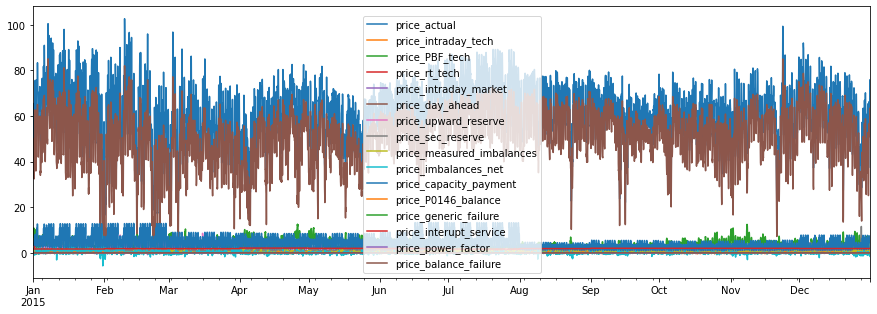

In [78]:
price_df.loc['2015'].plot(figsize=(15,5));

In [91]:
price_df['diff'] = abs(price_df.price_actual - price_df['sum'])

In [107]:
missing = price_df.loc[price_df['sum'] != price_df.price_actual].copy()

missing.loc[:'2017'].isna().sum()

price_actual                    0
price_intraday_tech          1487
price_PBF_tech               2231
price_rt_tech                3671
price_intraday_market        1487
price_day_ahead              2208
price_upward_reserve          744
price_sec_reserve             744
price_measured_imbalances     744
price_imbalances_net          744
price_capacity_payment       5063
price_P0146_balance          8975
price_generic_failure        9767
price_interupt_service          0
price_power_factor              0
price_balance_failure           0
sum                             0
diff                            0
dtype: int64

In [103]:
missing.loc['2016']

,price_actual,price_intraday_tech,price_PBF_tech,price_rt_tech,price_intraday_market,price_day_ahead,price_upward_reserve,price_sec_reserve,price_measured_imbalances,price_imbalances_net,price_capacity_payment,price_P0146_balance,price_generic_failure,price_interupt_service,price_power_factor,price_balance_failure,sum,diff
2016-03-01 00:00:00,32.29,0.0,2.49,0.07,0.00,25.00,0.0,1.13,0.18,0.33,1.31,NaN,NaN,1.87,-0.07,0.00,32.31,0.02
2016-03-01 01:00:00,27.56,0.0,2.99,0.05,0.00,20.00,0.0,1.37,0.45,-0.21,1.11,NaN,NaN,1.87,-0.07,-0.01,27.55,0.01
2016-03-01 03:00:00,26.39,0.0,3.99,0.04,0.00,18.35,0.0,0.88,0.53,-0.18,0.98,NaN,NaN,1.87,-0.07,-0.01,26.38,0.01
2016-03-01 04:00:00,26.95,0.0,3.95,0.04,0.00,19.10,0.0,0.88,0.40,-0.21,0.96,NaN,NaN,1.87,-0.07,-0.01,26.91,0.04
2016-03-01 05:00:00,28.07,0.0,3.78,0.08,0.01,20.00,0.0,1.30,0.34,-0.41,0.97,NaN,NaN,1.87,-0.07,-0.01,27.86,0.21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-31 19:00:00,78.41,0.0,NaN,0.05,0.04,NaN,NaN,NaN,NaN,NaN,3.89,NaN,NaN,1.88,-0.05,-0.03,5.78,72.63
2016-12-31 20:00:00,77.64,0.0,NaN,0.23,0.09,NaN,NaN,NaN,NaN,NaN,3.92,NaN,NaN,1.88,-0.05,-0.03,6.04,71.60
2016-12-31 21:00:00,77.32,0.0,NaN,0.11,-0.02,NaN,NaN,NaN,NaN,NaN,3.88,NaN,NaN,1.88,-0.05,-0.03,5.77,71.55
2016-12-31 22:00:00,74.07,0.0,NaN,1.73,-0.06,NaN,NaN,NaN,NaN,NaN,2.81,NaN,NaN,1.88,-0.05,-0.08,6.23,67.84


In [76]:
missing = price_df.loc[price_df['sum'] != price_df.price_actual, ['price_actual', 'sum']].copy()
missing.groupby(by=[missing.index.year, missing.index.month]).count().head(60)

price_actual  sum
2015 3            644  644
     4              1    1
     5            679  679
     6              1    1
     7            715  715
     8              1    1
     9            680  680
2016 3            633  633
     4              1    1
     5            614  614
     12           744  744
2017 1            744  744
     2            672  672
     3            744  744
     4            720  720
     5            744  744
     6            719  719
     8              1    1
     9            687  687
     11           720  720
2018 1              0  744
     2              0  672
     3              0  744
     4              0  720
     5              0  744
     6              0  720
     7              0  744
     8              0  744
     9              0  720
     10             0  744
     11             0  720
     12             0  744
2019 1              0  744
     2              0  672
     3              0  744
     4              0  720
     5              0  744
     6              0  720
     7              0  744
     8              0  744
     9              0  720
     10             0  744
     11             0  720
     12             0  744
2020 1              0  744
     2              0  696
     3              0  744
     4              0  720
     5              0  744
     6              0  720
     7              0  744
     8              0  744
     9              0  720
     10             0  744
     11             0  720
     12             0  744
2021 1              0  744
     2              0  672
     3              0  744
     4              0  720

In [74]:
price_df.loc['2015-3-1']

,price_actual,price_intraday_tech,price_PBF_tech,price_rt_tech,price_intraday_market,price_day_ahead,price_upward_reserve,price_sec_reserve,price_measured_imbalances,price_imbalances_net,price_capacity_payment,price_P0146_balance,price_generic_failure,price_interupt_service,price_power_factor,price_balance_failure,sum
2015-03-01 00:00:00,47.60,0.0,5.56,0.01,-0.21,35.62,0.0,1.42,0.12,0.12,3.23,NaN,NaN,1.83,-0.07,0.0,47.63
2015-03-01 01:00:00,40.01,0.0,6.43,0.00,-0.04,27.10,0.0,1.82,0.10,-0.03,2.91,NaN,NaN,1.83,-0.07,0.0,40.05
2015-03-01 02:00:00,37.79,0.0,6.89,0.02,-0.19,25.00,0.0,1.62,0.57,-0.57,2.70,NaN,NaN,1.83,-0.07,0.0,37.80
2015-03-01 03:00:00,33.06,0.0,7.48,0.00,-0.47,20.01,0.0,1.70,0.62,-0.59,2.55,NaN,NaN,1.83,-0.07,0.0,33.06
2015-03-01 04:00:00,29.65,0.0,7.88,0.00,-0.29,17.10,0.0,1.03,0.46,-0.76,2.47,NaN,NaN,1.83,-0.07,0.0,29.65
2015-03-01 05:00:00,31.25,0.0,7.85,0.14,-0.22,17.22,0.0,1.39,0.42,0.27,2.42,NaN,NaN,1.83,-0.07,0.0,31.25
2015-03-01 06:00:00,33.55,0.0,7.42,0.16,-0.15,20.14,0.0,1.18,0.54,0.06,2.40,NaN,NaN,1.83,-0.07,0.0,33.51
2015-03-01 07:00:00,31.95,0.0,7.35,0.15,-0.15,19.87,0.0,0.97,0.36,-0.83,2.47,NaN,NaN,1.83,-0.07,0.0,31.95
2015-03-01 08:00:00,37.89,0.0,8.34,0.26,-0.08,20.22,0.0,1.86,0.20,1.37,4.06,NaN,NaN,1.83,-0.07,0.0,37.99
2015-03-01 09:00:00,40.43,0.0,7.25,0.00,-0.02,25.22,0.0,1.33,0.20,0.11,4.53,NaN,NaN,1.83,-0.07,0.0,40.38


In [55]:
type(price_df.loc[price_df['sum'] != price_df.price_actual, ['price_actual', 'sum']].values[0][0])

numpy.float64

In [116]:
# Change directory and get all files in data/price directory
os.chdir('../data/price')
files = os.listdir()
files.remove('missing')


# Read all files in directory
prices = pd.DataFrame()
for file in files:
    prices =pd.concat([prices, pd.read_csv(file, delimiter=';', index_col=5, parse_dates=True)])

# Join on date_range to make sure we aren't missing any rows
price_df = pd.DataFrame(
    index=pd.date_range(start=dt.datetime(2015,1,1),
                        end=dt.datetime(2021,12,31,23),
                        freq='H',
                        tz='CET')
)

cols = {'Hourly average price final sum of components':'price_actual',
       'Hourly average price intraday market tech. constraints component':'price_intraday_tech',
       'Hourly average price PBF technical constraints component':'price_PBF_tech',
       'Hourly average price real time technical constraints component':'price_rt_tech',
       'Hourly average price intraday market component':'price_intraday_market',
       'Hourly average price Day Ahead market component':'price_day_ahead',
       'Hourly average price Upward reserve power component':'price_upward_reserve',
       'Hourly average price secondary reserve component':'price_sec_reserve',
       'Hourly average price measured imbalances component': 'price_measured_imbalances',
       'Hourly average price imbalances net value component':'price_imbalances_net',
       'Hourly average price capacity payment component':'price_capacity_payment',
       'Hourly average price P.O.14.6 balance component':'price_P0146_balance',
       'Hourly average price Generic Units Nom. Failure component':'price_generic_failure',
       'Hourly average price interruptibility service component':'price_interupt_service',
       'Hourly average price power factor control component':'price_power_factor',
       'Hourly average price balance energy failure component':'price_balance_failure'}

# Create price dictionary to hold column data
price_dict = {cols[col]:prices.loc[prices.name==col, 'value'] for col in cols.keys()}

# For each column, add to price_df
for key in price_dict.keys():
    price_dict[key] = price_dict[key].rename(key)
    price_df = price_df.join(price_dict[key].groupby(by=price_dict[key].index).mean())

# Drop all the duplicates
price_df = price_df.groupby(by=price_df.index).mean().copy()

# Make timezone unaware, shift by an hour to offset the unaware tz
price_df.index = price_df.index.tz_convert(None)
price_df = price_df.shift(1, freq='H')

#price_df.fillna(value=0, inplace=True)
# Change directory back to ../script
os.chdir('../../scripts')

## Combine dataframes

In [12]:
# Create df with date_range and copy it to second df
df = pd.DataFrame(
    index=pd.date_range(start = dt.datetime(2014,12,31),
                        end = dt.datetime(2022,1,1,23),
                        freq = 'H')
)
df_lag = df.copy()

# Join all non-lagged data to create df, and lagged data to created lagged
df = df.join([weather, border, gen, load_forecast, ws, gen_forecast, price_df])
df_lag = df_lag.join([weather_lag, border_lag, gen_lag, load_forecast, ws_lag, gen_forecast, price_df])


# Drop last day since no price data for 2022
df.dropna(inplace=True)
df_lag.dropna(inplace=True)

# Export to clean folder
df.to_csv('../data/clean/df_clean.csv')
df_lag.to_csv('../data/clean/df_clean_lag.csv')